In [30]:
#Import library
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score


In [32]:
train_dir = "/kaggle/input/dataset-10/Dataset/Train"
val_dir = "/kaggle/input/dataset-10/Dataset/Valid"
test_dir = "/kaggle/input/dataset-10/Dataset/Test"

# **PREPOCESSING**

In [33]:
#Data Augmentation
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip = True,
    rotation_range = 0.4,
    zoom_range = 0.4,
    width_shift_range = 0.4,
    height_shift_range = 0.4,
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.
)

In [34]:
#Declare size & Batch
train_batch_size = 30
val_batch_size = 30
test_batch_size = 30
img_height = 150
img_width = 150

In [48]:
train_ds = train_generator.flow_from_directory(
    directory = train_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = train_batch_size,
    shuffle = True,
    seed = 42,
)

val_ds = val_generator.flow_from_directory(
    directory = val_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = val_batch_size,
    shuffle = True,
    seed = 42,
)

test_ds = test_generator.flow_from_directory(
    directory = test_dir,
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = test_batch_size,
    shuffle = False
)

Found 787 images belonging to 10 classes.
Found 202 images belonging to 10 classes.
Found 84 images belonging to 10 classes.


In [36]:
#Display class
class_names = train_ds.class_indices
print(class_names)

{'ayam goreng': 0, 'capcay': 1, 'daging rendang': 2, 'gudeg': 3, 'mie goreng': 4, 'nasi goreng': 5, 'sate ayam': 6, 'soto lamongan': 7, 'tahu sumedang': 8, 'tempe goreng': 9}


In [37]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(30, 150, 150, 3)
(30, 10)


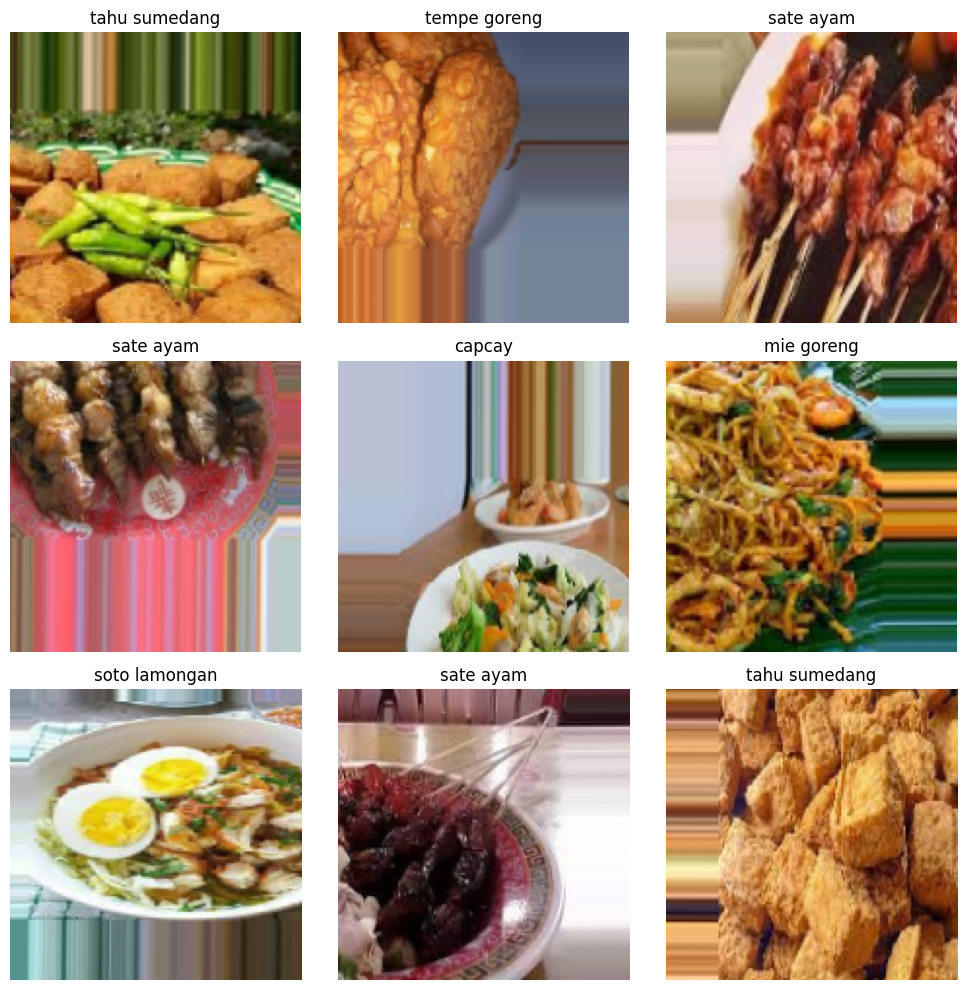

In [38]:
# Fetch the first batch of images and labels from train_ds
images, labels = next(train_ds)

# Display the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])

    # Retrieve the label index from the one-hot encoded format
    label_index = np.argmax(labels[i])

    # Get the class name corresponding to the label index
    for class_name, index in train_ds.class_indices.items():
        if index == label_index:
            plt.title(class_name)
            break

    plt.axis("off")

plt.tight_layout()
plt.show()


# **MAKE THE MODEL**

In [39]:
pre_trained_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=None,
    alpha=1.0,
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)



In [40]:
# Define the custom callback
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.95:
            print("\nReached 95% validation accuracy. Stopping training.")
            self.model.stop_training = True

In [41]:
# Adding more layer in top of based model for fine tuning
inputs = pre_trained_model.input

x = tf.keras.layers.Flatten()(pre_trained_model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)  # Adjust the number of neurons
x = tf.keras.layers.Dropout(0.5)(x)  # Increase dropout

outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [42]:
# Unfreeze layers for fine-tuning
for layer in pre_trained_model.layers:
    layer.trainable = True

# Set up the custom callback
custom_callback = CustomCallback()

# Compile the model after unfreezing layers
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['acc'])

In [43]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 98% accuracy
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = 400)

Epoch 1/400
27/27 [==============================] - 52s 541ms/step - loss: 2.3107 - acc: 0.1233 - val_loss: 2.3027 - val_acc: 0.0594
Epoch 2/400
27/27 [==============================] - 10s 380ms/step - loss: 2.2947 - acc: 0.1321 - val_loss: 2.3016 - val_acc: 0.0743
Epoch 3/400
27/27 [==============================] - 10s 378ms/step - loss: 2.2881 - acc: 0.1144 - val_loss: 2.3005 - val_acc: 0.0792
Epoch 4/400
27/27 [==============================] - 10s 375ms/step - loss: 2.2867 - acc: 0.1487 - val_loss: 2.2992 - val_acc: 0.0792
Epoch 5/400
27/27 [==============================] - 10s 388ms/step - loss: 2.2690 - acc: 0.1715 - val_loss: 2.2973 - val_acc: 0.0792
Epoch 6/400
27/27 [==============================] - 10s 380ms/step - loss: 2.2685 - acc: 0.1499 - val_loss: 2.2948 - val_acc: 0.1089
Epoch 7/400
27/27 [==============================] - 10s 372ms/step - loss: 2.2616 - acc: 0.1931 - val_loss: 2.2917 - val_acc: 0.1139
Epoch 8/400
27/27 [==============================] - 10s 375ms

# **EVALUATION**

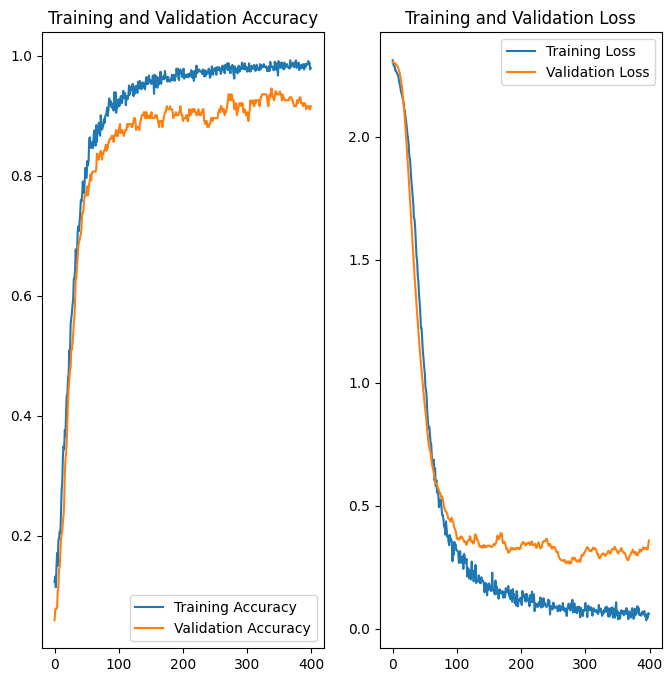

In [44]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 2s 294ms/step
y_pred : [9 0 0 0 0 0 0 0 0 0 1 8 3 1 1 1 2 7 0 2 2 2 3 3 3 3 3 3 4 4 5 4 4 4 4 4 4
 4 5 5 5 5 5 5 5 7 5 5 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 9 8 8
 8 8 8 9 0 9 9 9 9 9] 

y_true : [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 4 4 4 4
 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8
 8 8 8 8 8 9 9 9 9 9] 



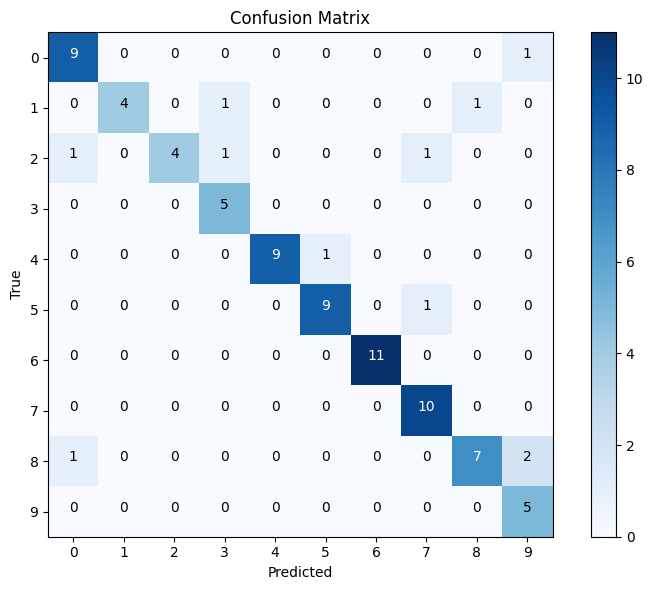


F1 Score: 0.8668753482663256


In [45]:
# Get predictions from the model on test data
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)
print("y_pred :",y_pred,"\n")

# Get actual labels from test data
y_true = test_ds.classes
print("y_true :",y_true,"\n")
# Create a confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Displaying the confusion matrix using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(confusion, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = len(np.unique(y_true))
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))

plt.xlabel('Predicted')
plt.ylabel('True')

# Add the numbers in the confusion matrix box
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, confusion[i, j],
                 horizontalalignment='center',
                 color='white' if confusion[i, j] > (confusion.max() / 2) else 'black')

plt.tight_layout()
plt.show()

# Calculating F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print("\nF1 Score:", f1)

1/1 [==============================] - 0s 39ms/step
y_true: 6, y_pred: 6
y_true: 9, y_pred: 9
y_true: 0, y_pred: 0
y_true: 1, y_pred: 1
y_true: 5, y_pred: 5
y_true: 7, y_pred: 7
y_true: 8, y_pred: 8
y_true: 1, y_pred: 1
y_true: 3, y_pred: 3


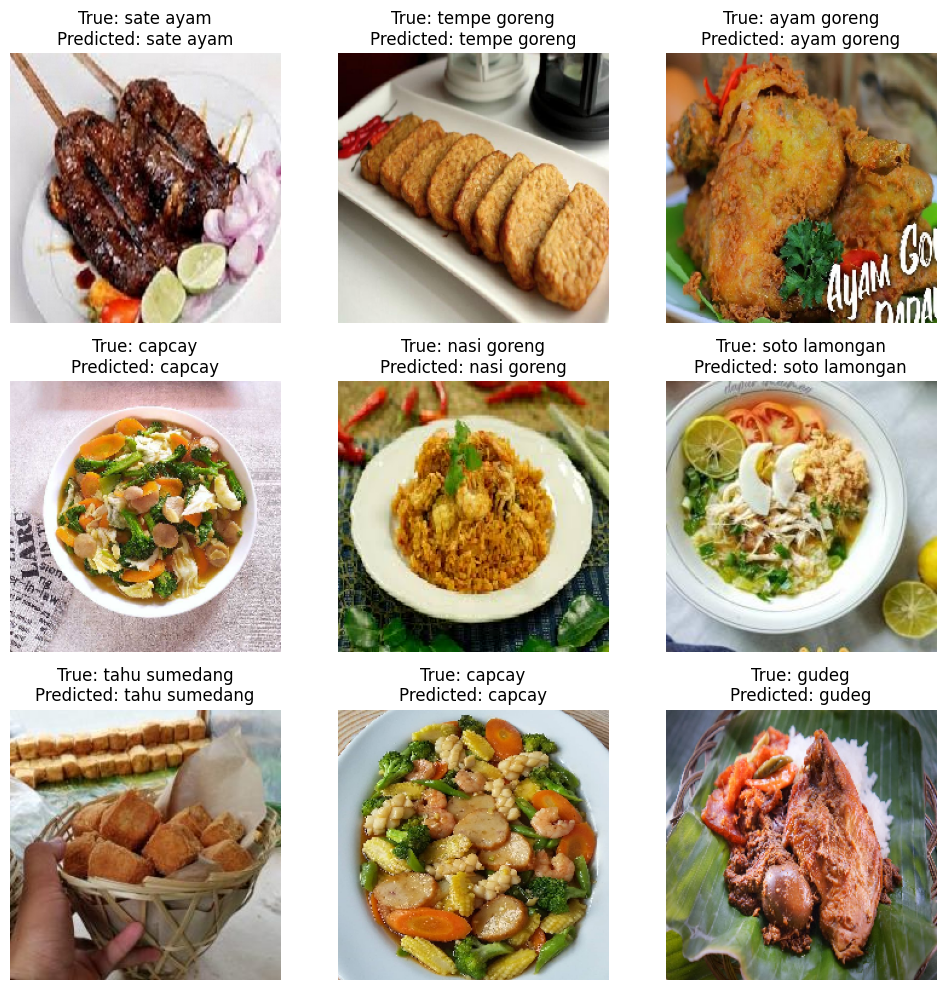

In [50]:
# Retrieve data from test_ds
test_images, test_labels = next(test_ds)

# Predict labels using models you already have
predicted_labels = model.predict(test_images)

# Display to compare images, actual labels, and predicted labels
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])

    # Take the actual label
    true_label_index = np.argmax(test_labels[i])
    for class_name, index in test_ds.class_indices.items():
        if index == true_label_index:
            true_label = class_name
            break

    # Retrieve the prediction label
    predicted_label_index = np.argmax(predicted_labels[i])
    for class_name, index in test_ds.class_indices.items():
        if index == predicted_label_index:
            predicted_label = class_name
            break

    # Compare and display actual labels and predicted labels
    title = f"True: {true_label}\nPredicted: {predicted_label}"
    plt.title(title)
    plt.axis("off")
    print(f"y_true: {true_label_index}, y_pred: {predicted_label_index}")


plt.tight_layout()
plt.show()

# **CONVERT**

In [47]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)